**Developed by:** [Georgii Bocharov](https://github.com/georgebv)

**E-Mail:** bocharovgeorgii@gmail.com

**pyextremes:** https://github.com/georgebv/pyextremes

# Introduction
This notebook provides a basic (yet, likely, the most common in everyday usage) example of how the [pyextremes](https://github.com/georgebv/pyextremes) library can be used to perform the Extreme Value Analysis (EVA).

# Set up the environment
First, we need to setup the environment. In this tutorial we will cover the most common, top-level interface of the `pyxtremes` library - the `EVA` class. Let's import it:

In [1]:
from pyextremes import EVA, __version__
print("pyextremes", __version__)

pyextremes 2.3.2


`EVA` is a class which provides interface to the most important features of the `pyxtremes` library. It allows to perform all key tasks comprising the Extreme Value Analysis, such as:
- extraction of extreme values using either Block Maxima (`BM`) or Peaks-over-Threshold (`POT`) methods
- fitting a model to the extracted extreme values using either Maximum Likelihood Estimate (`MLE`, built as a wrapper around [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) distributions) or Markov Chain Monte Carlo (MCMC, called `Emcee` as it's built around the [emcee](https://emcee.readthedocs.io/en/stable/) library by Dan Foreman-Mackey)
- inference of extreme values associated with given return periods (exceedance probabilities) using the selected model and graphical visualization of results

For each of the analysis phases listed above the `EVA` class provides a rich assortment of tools for analytics, visualization, and reporting. All of these tools are conveniently wrapped within the `EVA` class interface and require minimum knowledge of the API by the user.

Now, let's import other packages required for this notebook:

In [2]:
import numpy as np
import pandas as pd

# Load the data
First, we need to load the data which will be used in this tutorial. Data provided to the `pyextremes.EVA` class must meet the following criteria:
- it must be a `pandas.Series` object
- its index must be a sequence of date-time objects
- it should be sorted in ascending order along its index
- it should contain no `nan` entries and all values must be numeric

Data used in this tutorial represents timeseries of water levels obtained from the New York City [the Battery](https://tidesandcurrents.noaa.gov/stationhome.html?id=8518750) tidal station. Data for this station was extracted using the [coastlib](https://github.com/georgebv/coastlib) library which provides an interface to the [NOAA CO-OPS API](https://tidesandcurrents.noaa.gov/api/).

Let's load and pre-process the data:

In [3]:
data = (
    pd
    .read_csv("../data/battery_wl.csv", index_col=0, parse_dates=True, squeeze=True)
    .sort_index(ascending=True)
    .astype(float)
    .dropna()
)
data.head()

C:\Users\ggungor\AppData\Local\Temp\ipykernel_18912\1688907363.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  .read_csv("../data/battery_wl.csv", index_col=0, parse_dates=True, squeeze=True)


Date-Time (GMT)
1920-06-01 05:00:00   -0.659
1920-06-01 06:00:00   -0.873
1920-06-01 07:00:00   -1.025
1920-06-01 08:00:00   -0.964
1920-06-01 09:00:00   -0.659
Name: Water Elevation [m NAVD88], dtype: float64

<Axes: xlabel='Date-Time (GMT)'>

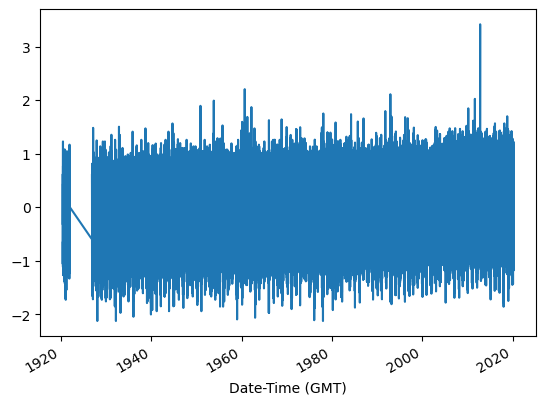

In [4]:
data.plot()

Before proceeding further, let's remove entries before the large gap before 1925 and detrend the data by removing a linear trend (mean sea level rise, 2.87mm/yr for this area) around the current tidal epoch (1992). This linear trend represents sea level rise, which is deterministic and is not related to random variations in water elevations. 

In [5]:
data = data.loc[pd.to_datetime("1925"):]
data = data - (data.index.array - pd.to_datetime("1992")) / pd.to_timedelta("365.2425D") * 2.87e-3
data.head()

Date-Time (GMT)
1926-11-20 05:00:00   -0.411120
1926-11-20 06:00:00   -0.777120
1926-11-20 07:00:00   -1.051120
1926-11-20 08:00:00   -1.051121
1926-11-20 09:00:00   -0.808121
Name: Water Elevation [m NAVD88], dtype: float64

<Axes: xlabel='Date-Time (GMT)'>

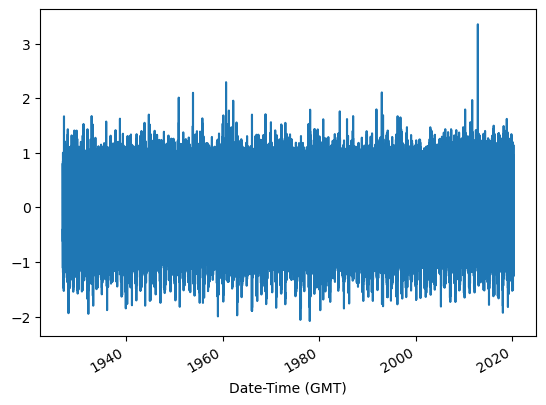

In [6]:
data.plot()

# Initialize the EVA object
After the data has been pre-processed and is ready for extreme value analysis, we can initialize the `EVA` object. The `EVA` class takes only one parameter - `data`. Let's do this:

In [7]:
model = EVA(data=data)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:    Water Elevation [m NAVD88]      Size:                             796,751
Start:                      November 1926      End:                           March 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

As seen above, the text representation of the `EVA` object shows a brief summary of the state of the model. It also suggests sequence in which the analysis should be performed.

# Extract extreme values
Having the `EVA` object initialized, we are ready to perform the first step of the analysis - extreme value extraction. In this tutorial we will use the Block Maxima (`BM`) extraction method with a block size of 1 year. What this means in the framework of the model is that the data is split into one-year blocks and within each of the blocks the highest value is found and added to the `extremes` series. Let's extract the extreme values using this method:

In [8]:
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:    Water Elevation [m NAVD88]      Size:                             796,751
Start:                      November 1926      End:                           March 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 94      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

Detailed description of parameters passed to the `get_extremes` method are provided in the docstrings:

In [9]:
help(EVA.get_extremes)

Help on function get_extremes in module pyextremes.eva:

get_extremes(self, method: "typing.Literal['BM', 'POT']", extremes_type: "typing.Literal['high', 'low']" = 'high', **kwargs) -> 'None'
    Get extreme events from time series.
    
    Extracts extreme values from the 'self.data' attribute.
    Stores extreme values in the 'self.extremes' attribute.
    
    Parameters
    ----------
    method : str
        Extreme value extraction method.
        Supported values:
            BM - Block Maxima
            POT - Peaks Over Threshold
    extremes_type : str, optional
        high (default) - get extreme high values
        low - get extreme low values
    kwargs
        if method is BM:
            block_size : str or pandas.Timedelta, optional
                Block size (default='365.2425D').
                See pandas.to_timedelta for more information.
            errors : str, optional
                raise (default) - raise an exception
                    when encountering a

A great way to visually asses the extracted extreme values is to plot them agains the original time series. This can be done using the `plot_extremes` method. In the case of Block Maxima extraction method, block boundaries are shown.

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Date-Time (GMT)', ylabel='Water Elevation [m NAVD88]'>)

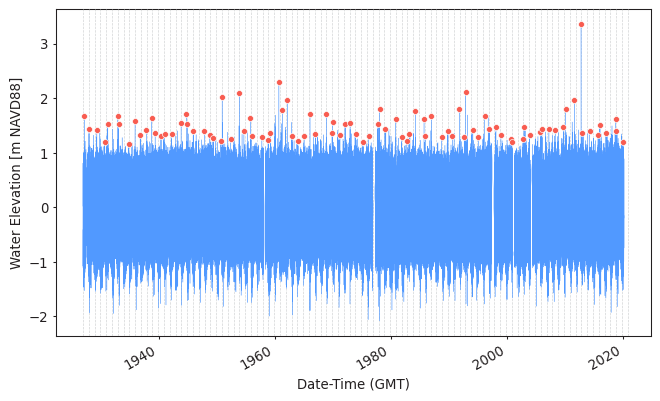

In [10]:
model.plot_extremes()

# Fit a model
The next step of the analysis is fitting a model to the extracted extreme values. Two fitting models are available: `MLE` (maximum likelihood) and `Emcee` (Markov Chain Monte Carlo). In this tutorial the default `MLE` model is used. It's a simple model which finds a point estimate of distribution parameters and calculates confidence intervals using bootstrap monte carlo. The two key parameters required by a model are: `model` - a model name, and `distribution` - distribution name, compliant with [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) distribution names. By default the model select best distribution using the Akaike Information Criterion (AIC). For Block Maxima this selection is performed between GEV (Generalized Extreme Value) and Gumbel distributions.

In [11]:
model.fit_model()
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:    Water Elevation [m NAVD88]      Size:                             796,751
Start:                      November 1926      End:                           March 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 94      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

Detailed description of parameters passed to the `fit_model` method are provided in the docstrings:

In [12]:
help(model.fit_model)

Help on method fit_model in module pyextremes.eva:

fit_model(model: "typing.Literal['MLE', 'Emcee']" = 'MLE', distribution: 'typing.Union[str, scipy.stats.rv_continuous]' = None, distribution_kwargs: 'typing.Optional[dict]' = None, **kwargs) -> 'None' method of pyextremes.eva.EVA instance
    Fit a model to the extracted extreme values.
    
    Parameters
    ----------
    model : str, optional
        Name of model. By default it is 'MLE'.
        Name of model.
        Supported models:
            MLE - Maximum Likelihood Estimate (MLE) model.
                Based on 'scipy' package (scipy.stats.rv_continuous.fit).
            Emcee - Markov Chain Monte Carlo (MCMC) model.
                Based on 'emcee' package by Daniel Foreman-Mackey.
    distribution : str or scipy.stats.rv_continuous, optional
        Distribution name compatible with scipy.stats
        or a subclass of scipy.stats.rv_continuous.
        See https://docs.scipy.org/doc/scipy/reference/stats.html
        By

A quick way to analyze quality of the model is to use a method called `plot_diagnostic`. This method provides a two-by-two plot showing return values, PDF, Q-Q, and P-P plots. Let's plot it:

(<Figure size 768x768 with 4 Axes>,
 (<Axes: title={'center': 'Return value plot'}, xlabel='Return period', ylabel='Water Elevation [m NAVD88]'>,
  <Axes: title={'center': 'Probability density plot'}, xlabel='Water Elevation [m NAVD88]', ylabel='Probability density'>,
  <Axes: title={'center': 'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <Axes: title={'center': 'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

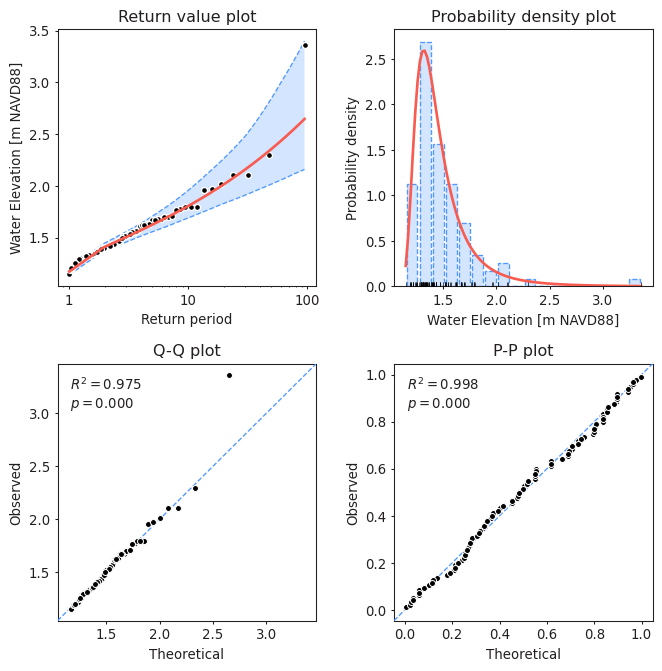

In [13]:
model.plot_diagnostic(alpha=0.95)

The first time confidence intervals are calculated the model may run slow. However, as results of calculations related to return values and confidence intervals are hashed internally, all subsequent calls with the same parameters should be nearly instantaneous.

# Get output
As the extreme values have been extracted and a model has been fit to the data, we are ready to produce a return value plot and get a summary of projected extreme return values. Let's do this:

(<Figure size 768x480 with 1 Axes>,
 <Axes: xlabel='Return period', ylabel='Water Elevation [m NAVD88]'>)

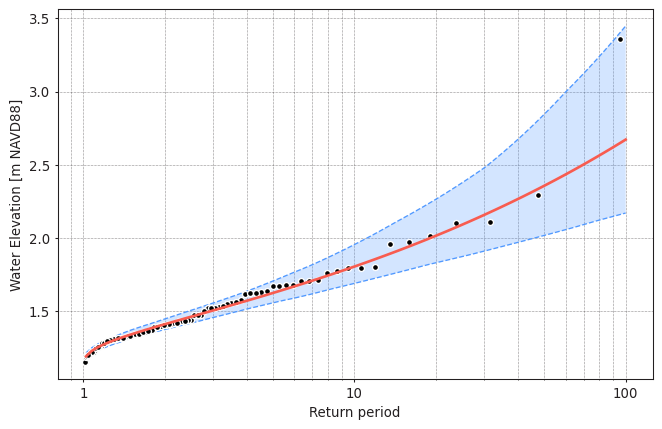

In [14]:
model.plot_return_values(
    return_period=np.logspace(0.01, 2, 100),
    return_period_size="365.2425D",
    alpha=0.95,
)

In [15]:
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95,
    n_samples=1000,
)
summary

,return value,lower ci,upper ci
return period,,,
1.0,0.802610,-0.499861,1.028085
2.0,1.409343,1.369090,1.456062
5.0,1.622565,1.548008,1.706420
10.0,1.803499,1.680434,1.954631
25.0,2.090267,1.859372,2.404115
50.0,2.354889,2.002209,2.870849
100.0,2.671313,2.150418,3.519063
250.0,3.188356,2.345126,4.770237
500.0,3.671580,2.499525,6.086012


This concludes the tutorial. For tutorials covering more advanced topics such as model selection, custom distributions, peaks-over-threshold extreme process modeling, threshold selection, and others see the [pyextremes GitHub page](https://github.com/georgebv/pyextremes).